In [68]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from surrogate import SurrogateNet_multiMLP, geometric_position, geometric_reshape, visualize
from calc_init_param import calc_next_param
from core.param_util.param_tools import gen_param_csv
from automation import run_cmd
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import shutil
from surrogate_springback import SurrogateNet_springback
import matplotlib.pyplot as plt



In [69]:
class bending_env(gym.Env):
    def __init__(self, n_actions, episode=1000):

        # Define the state space size
        self.state_space = spaces.Box(low=0, high=200, shape=(3, 7, 72), dtype=np.float32)

        # Define the action space size
        self.action_space = spaces.Discrete(n=n_actions, start=1)

        # Initialize the current state with the stress distribution after pre-stretch
        self.state = None

        self.pre_idx = None
        self.pre_param = [321.1,0.0,0.0,0,-0.0,0.0]  # Pre-stretch length

        self.strip_length = 40
        self.pre_length = 0.1
        self.k = 0.05

        # Surrogate model
        self.model = SurrogateNet_multiMLP(1512, 1512)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        checkpoint = torch.load("/Optimizing_bending_parameter/Surrogate_model.pth")
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Bending Parameter list
        self.param_list = []  # To be considered: add the pre-stretch parameter to it

        self.action_list = []  # Record series of actions for each episode for future use

        self.max_step = 10  # Max number of bending steps

        self.num_episode = episode

        self.mould_name = "test" + str(self.num_episode)

        self.rec = geometric_reshape()
        
        # Some useful data path
        self.data_path_2 = "./data/mould_output/" + self.mould_name
        self.data_path_1 = "./data/model/" + self.mould_name

    def reset(self):
        # Reset the environment
        self.num_episode += 1
        self.mould_name = "test" + str(self.num_episode)
        self.data_path_2 = "./data/mould_output/" + self.mould_name
        self.data_path_1 = "./data/model/" + self.mould_name

        # Generate curve and mould for this episode
        print(self.mould_name)
        if not os.path.exists(self.data_path_2):
            os.makedirs(self.data_path_2)
        if not os.path.exists(self.data_path_1):
            os.makedirs(self.data_path_1)
        cmd = ['python ', 'gen_curve_and_mould.py', self.mould_name]
        # print(cmd)
        
        run_cmd(cmd)
        shutil.copy(self.data_path_2 + '/mould.stp', self.data_path_1)

        '''
            Initialize the state with the stress distribution after pre-stretch.
            Since the pre-strech steps are all the same for each test, we simply used the one of test 0.
        '''
        
        csv_path = "/Optimizing_bending_parameter/data/model/test0/simulation/strip_mises_Step-0.csv"
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            x = df["S_Mises"]
            x = torch.tensor(x, dtype=torch.float32)
        self.state = x
        # geometric_position(self.rec, x)

        self.action_list = []  # Empty the action series
        self.param_list = []  # Empty the param list
        self.pre_idx = None  # Reset pre_idx

        # Perform the pre-stretch step
        next_param, self.pre_idx = calc_next_param("./data/mould_output/" + self.mould_name, 0, 
                                                    self.strip_length, 
                                                    self.pre_length, 
                                                    self.k, 
                                                    self.pre_idx)
        self.param_list.append(next_param)
        # visualize(self.state, self.state, self.rec)
        return self.state

    def step(self, action):
        self.action_list.append(action)
        # print(self.state) 

        # Adding the next parameter to the list
        next_param, self.pre_idx = calc_next_param("./data/mould_output/" + self.mould_name, action, 
                                                    self.strip_length, 
                                                    self.pre_length, 
                                                    self.k, 
                                                    self.pre_idx)
        self.param_list.append(next_param)
        t = (np.array(next_param - np.array(self.param_list[-2]))).tolist()
        t = torch.tensor(t[:2] + [t[5]], dtype=torch.float32)
        # print(t)

        # Execute the given action and return the next state, reward, and whether the episode is done
        self.model.eval()
        with torch.no_grad():
            self.state = self.model(self.state, t)  # Surrogate model as transition function
            # visualize(self.state, self.state, self.rec)
        
        # Check if the episode is done and calculate the reward
        if self.pre_idx == 1999 or len(self.action_list) == self.max_step:
            # reward = 100 - self.reward_surrogate(self.state)
            reward = 200 - max(self.state) - self.reward_surrogate(self.state)
            done = True
        else:
            reward = 100 - max(self.state)
            # reward = 0
            done = False  
        # print("Reward in this step: {}".format(reward))
        return self.state, reward, done, {}

    def reward_surrogate(self, final_state):
        self.reward_model = SurrogateNet_springback(self.rec)
        checkpoint = torch.load("/Optimizing_bending_parameter/Surrogate_springback_model.pth")
        self.reward_model.load_state_dict(checkpoint['model_state_dict'])
        
        final_state = final_state.double()
        
        self.reward_model.eval()
        with torch.no_grad():
            reward = self.reward_model(final_state)
        # print(reward)
        return reward


In [70]:
class Actor(nn.Module):
    def __init__(self, rec, n_actions, alpha):
        super(Actor, self).__init__()
        self.conv_module = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
       
        # Define the final fully connected layer for generating the action
        self.fc1 = nn.Linear(32 * 18 * 1 * 1, 64)  
        self.fc2 = nn.Linear(64, n_actions)
        self.rec = rec
        self.relu = nn.ReLU()
        # self.softmax = F.softmax()

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, stress):
        x = torch.tensor(geometric_position(self.rec, stress), dtype=torch.float32)
        
        # print(stress)
        x = self.conv_module(x)
            
        x = x.view(-1, 32 * 18 * 1 * 1)  # Flatten the output
            
        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        # print(self.fc2(x))
        probs = F.softmax(self.fc2(x))
        # print(probs)
        return probs

# Define the Critic network
class Critic(nn.Module):
    def __init__(self, rec, alpha):
        super(Critic, self).__init__()
        self.conv_module = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
       
        # Define the final fully connected layer for generating the action
        self.fc1 = nn.Linear(32 * 18 * 1 * 1, 64)  
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.rec = rec
        self.relu = nn.ReLU()

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

    def forward(self, stress):
        x = torch.tensor(geometric_position(self.rec, stress), dtype=torch.float32)
        # print(stress)
        x = self.conv_module(x)
        x = x.view(-1, 32 * 18 * 1 * 1)  # Flatten the output
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [71]:
class Agent():
    def __init__(self, n_actions, env, gamma=0.99, lr=1e-1):
        super(Agent, self).__init__()
        self.env = env
        self.actor = Actor(env.rec, n_actions, alpha=lr)
        self.critic = Critic(env.rec, alpha=lr)
        self.gamma = gamma
        self.log_probs = None

    def choose_action(self, observation):
        probs = self.actor.forward(stress=observation)
        # print(probs)
        dist = Categorical(probs)
        self.log_probs = dist.sample()
        action = dist.sample().numpy()[0]
        return action
        
    def learn(self, state, new_state, reward, done):
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()

        value_1 = self.critic.forward(state)
        value_2 = self.critic.forward(new_state)

        delta = reward + self.gamma * value_2 * (1-int(done)) - value_1

        critic_loss = delta ** 2
        actor_loss = -self.log_probs * delta
        param = self.actor.parameters()

        (actor_loss + critic_loss).backward()
        self.actor.optimizer.step()
        self.critic.optimizer.step()
            


In [72]:
N_games = 1010
bending_env = bending_env(n_actions=10)
# print(bending_env.rec)
agent = Agent(n_actions=10, env=bending_env)
score_history = []
while bending_env.num_episode < N_games:
    t_step = 1
    state = bending_env.reset()
    reward = 0
    while t_step < bending_env.max_step:
        action = agent.choose_action(state) + 1  # Don't allow action to be 0
        print("Action:{}".format(action))
        new_state, reward, done, _ = bending_env.step(action)
        if done:
            break
        agent.learn(state, new_state, reward, done)
        state = new_state
        t_step += 1
    score_history.append(float(reward))

    print('episode: ', bending_env.num_episode,'score: %.2f' % reward)
print(score_history)


test1001
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
episode:  1001 score: -6.17
test1002
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
Action:2
Action:2
Action:2
Action:2
Action:2
episode:  1002 score: -121.34
test1003
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
Action:2
Action:2
Action:2
episode:  1003 score: -36.00
test1004
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
Action:2
Action:2
Action:2
episode:  1004 score: -36.39
test1005
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
episode:  1005 score: -15.96
test1006
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
Action:2
episode:  1006 score: -23.03
test1007
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
Action:2
Action:2
Action:2
Action:2
episode:  1007 score: -42.12
test1008
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
episode:  1008 score: -14.86
test1009
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
Action:2
Action:2
episode:  1009 score: -30.90
test1010
gen_curve_and_mould.py Success
Action:2


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_8956\3384737347.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.fc2(x))


Action:2
Action:2
Action:2
Action:2
episode:  1010 score: -23.74
[-6.166208672285848, -121.34320068359375, -35.996696601354586, -36.389734878305674, -15.96308475051094, -23.0331949161942, -42.11740689839502, -14.861588229036993, -30.90462919037195, -23.741405124492065]


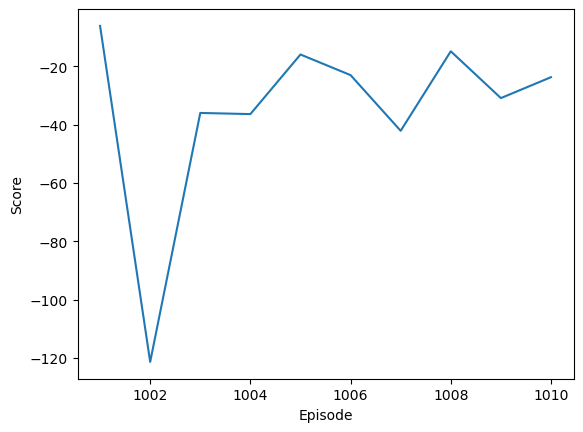

In [73]:
plt.plot(range(1001, N_games+1), score_history)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()
